In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report,roc_curve, precision_recall_curve, auc, make_scorer,recall_score, accuracy_score, precision_score, confusion_matrix,f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("data.csv")
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [4]:
lb = LabelBinarizer()
data['diagnosis'] = lb.fit_transform(data['diagnosis'].values)

In [5]:
y = data['diagnosis']
data.drop(['id', 'diagnosis','Unnamed: 32'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data, y,random_state=42,test_size=0.2,stratify=y)

# Chapter I : Improving sensitivity (Recall or True positive rate by decreasing the False negative FN)

In [6]:
clf = RandomForestClassifier(n_jobs=-1,random_state=42)
clf.fit(X_train, y_train)
y_proba = clf.predict_proba(X_test)
y_pred_prob =  y_proba[:, 1]

In summary:

    Use ‘predict’ for binary or multi-class classification problems when you want to get the predicted class label(s) for input data.
    Use ‘predict_proba’ for binary or multi-class classification problems when you want to get the probability estimates for each possible class label.
    Use ‘predict_log_proba’ when you need to work with very small or very large probability values, or when you want to avoid numerical underflow or overflow issues.
    Use ‘decision_function’ for binary classification problems with linear models when you want to get a score for each input data point.

In [7]:
predictions = clf.predict(X_test)
score_1 = accuracy_score(y_test, predictions)
classification_report_actual = classification_report(y_test, predictions) 
print(predictions, score_1, classification_report_actual, sep ='\n') 

[0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0
 0 0 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 1]
0.9736842105263158
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In the above classification report, we can see that our model precision value for (1) is 1 and recall value for (1) is 0.93. Since our goal  is to build a High-recall(sensitivity or true positive rate) ML model in predicting (1) without affecting precision to much, we need to  select the best value of Decision Threshold value form the below Precision-Recall curve, so that we could increase the sensitivity  of this model. I'd like to move the decision threshold to left to minimize the amount of false negatives, which would be especially important in cancer diagnoses.

Text(0.5, 1.0, 'Precision-Recall Curve')

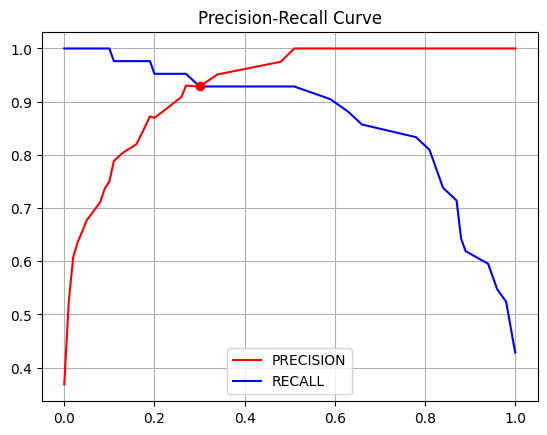

In [8]:
# Plot Precision-Recall curve using sklearn. 
from sklearn.metrics import precision_recall_curve 
from shapely.geometry import LineString

precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob) 
  
# Plot the output. 
plt.plot(threshold, precision[:-1], c ='r', label ='PRECISION') 
plt.plot(threshold, recall[:-1], c ='b', label ='RECALL')


line1 = LineString(np.column_stack((threshold, precision[:-1])))
line2 = LineString(np.column_stack((threshold, recall[:-1])))
intersection = line1.intersection(line2)

plt.plot(*intersection.xy,'ro')
#plt.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best')
plt.grid() 
plt.legend() 
plt.title('Precision-Recall Curve')

In [ ]:
x,y =intersection.xy
print("the best thershols between recall and precision is :",x[0])

the best thershols to have the best recall and the best precision is : 0.3

In [10]:
# Implementing main logic. 
  
# Based on analysis of the Precision-Recall curve. 
# Let Decision Threshold value be around 0.3... to get high Recall without affecting precision much. 
# Desired results. 
  
 
df = y_pred_prob 
  
# Set the value of decision threshold. 
decision_teshold = 0.3
  
# Desired prediction to increase recall value. 
desired_predict =[] 
  
# Iterate through each value of decision function output 
# and if  decision score is > than Decision threshold then, 
# append (1) to the empty list ( desired_prediction) else 
# append (0). 
for i in df: 
    if i<decision_teshold: 
        desired_predict.append(0) 
    else: 
        desired_predict.append(1) 

In [11]:
# Comparison 
  
# Old recall Value 
print("old recall value:", recall_score(y_test, predictions)) 
# New reccall Value   
print("new recall value:", recall_score(y_test, desired_predict)) 

old recall value: 0.9285714285714286
new recall value: 0.9285714285714286


we notice that is the same recall value so we need to try others methods to improve our goal : the recall value

In [12]:
print(pd.DataFrame(confusion_matrix(y_test, desired_predict),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))

     pred_neg  pred_pos
neg        69         3
pos         3        39


# Chapter II : Trying RandomizedSearch and GridSearch

In [13]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [14]:
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier(n_jobs=-1,random_state=42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 60, stop = 180, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 200, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [6, 7, 8,9,10,11,12,13,14,15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [8,9,10,11,12,13,14,15]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [8, 9, 10, 11, 12, 13, 14, 15],
 'min_samples_split': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'n_estimators': [60, 73, 86, 100, 113, 126, 140, 153, 166, 180]}


In [15]:
clf_random = RandomizedSearchCV(estimator = clf,random_state=42, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
clf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100, 120,
                                                      140, 160, 180, 200,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [8, 9, 10, 11, 12,
                                                             13, 14, 15],
                                        'min_samples_split': [6, 7, 8, 9, 10,
                                                              11, 12, 13, 14,
                                                              15],
                                        'n_estimators': [60, 73, 86, 100, 113,
                                                         126, 140, 153, 166,
                                                         180]},
                   random_state=42, verbose=2)

In [16]:
clf_random.best_params_

{'n_estimators': 126,
 'min_samples_split': 14,
 'min_samples_leaf': 15,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [17]:
clf_random.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=15, min_samples_split=14,
                       n_estimators=126, n_jobs=-1, random_state=42)

In [18]:
predictions_random = clf_random.predict(X_test)
score_1_random = accuracy_score(y_test, predictions_random)
classification_report_random = classification_report(y_test, predictions_random) 
print(predictions_random, score_1_random, classification_report_random, sep ='\n') 

[0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0
 0 0 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 1]
0.9385964912280702
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        72
           1       0.95      0.88      0.91        42

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



we see that recall has further decreased

In [19]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [1,5,8,10],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [5,10,15],
    'min_samples_split': [4,8,14],
    'n_estimators': [126,136, 146, 156]
}
# Create a based model
clf = RandomForestClassifier(n_jobs=-1,random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)

In [20]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 4,
 'n_estimators': 156}

In [21]:
best_grid = grid_search.best_estimator_

In [22]:
predictions_grid = best_grid.predict(X_test)
score_1_grid = accuracy_score(y_test, predictions_grid)
classification_report_grid = classification_report(y_test, predictions_grid) 
print(predictions_grid, score_1_grid, classification_report_grid, sep ='\n') 

[0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0
 0 0 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 1]
0.9649122807017544
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



we obtain optimal precision but not optimal recall

In [23]:
print(pd.DataFrame(confusion_matrix(y_test, predictions_grid),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))

     pred_neg  pred_pos
neg        72         0
pos         4        38


# Adjusting thershold until having 1 FN meaning by minimising FN to improve Recall

In [24]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [25]:
y_proba = best_grid.predict_proba(X_test)
y_pred_prob =  y_proba[:, 1]

In [26]:
# generate the precision recall curve
p, r, thresholds = precision_recall_curve(y_test, y_pred_prob)

In [32]:
def precision_recall_threshold(t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_pred_prob, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    

    
    score_1_adj = accuracy_score(y_test, y_pred_adj)
    classification_report_adj = classification_report(y_test, y_pred_adj) 
    print( score_1_adj, classification_report_adj, sep ='\n')


    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg        66         6
pos         1        41
0.9385964912280702
              precision    recall  f1-score   support

           0       0.99      0.92      0.95        72
           1       0.87      0.98      0.92        42

    accuracy                           0.94       114
   macro avg       0.93      0.95      0.94       114
weighted avg       0.94      0.94      0.94       114



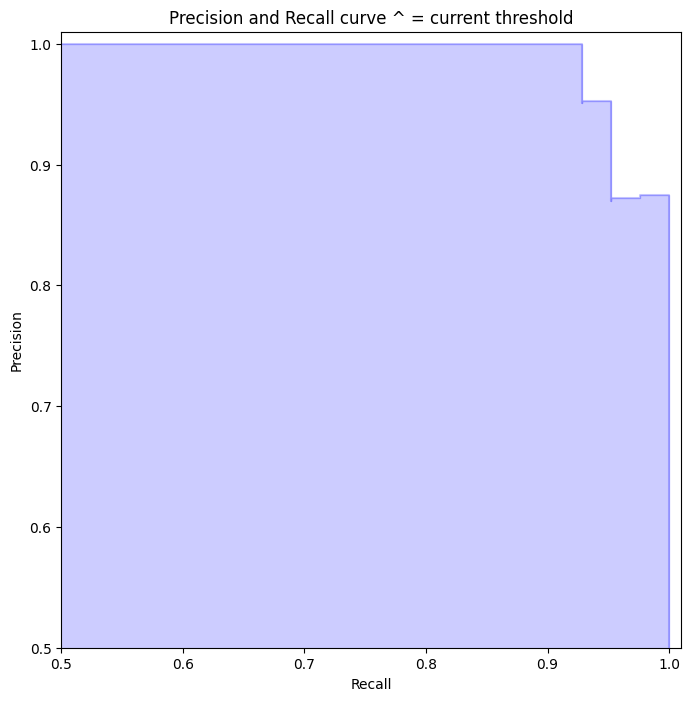

In [38]:
# The best I could do with 1 FN was 0.2, but re-execute to watch the confusion matrix change.
precision_recall_threshold(0.2)

Finally, the ROC curve shows that to achieve a 1.0 recall, we must accept some false positive rate > 0.0.


In [29]:
# Compute the false positive rate (FPR)  
# and true positive rate (TPR) for different classification thresholds 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.9953703703703703


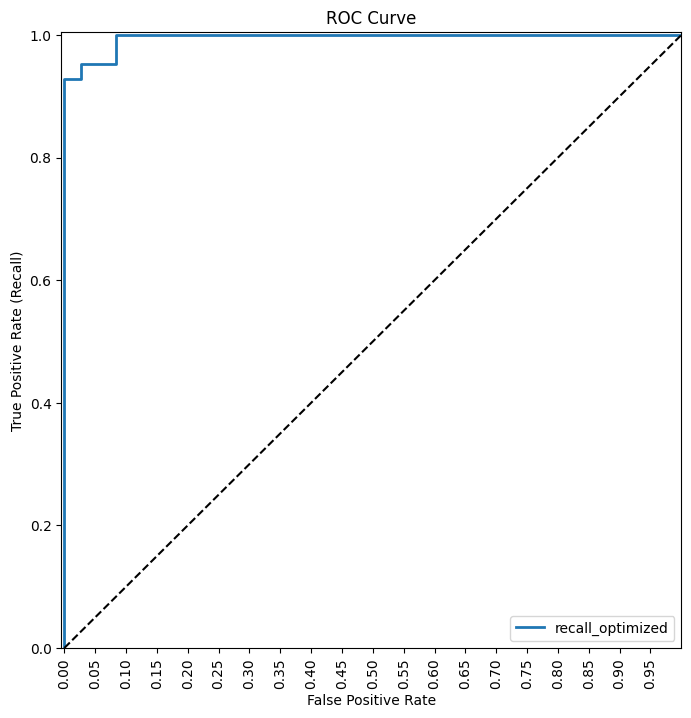

In [31]:
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')